# 1. Install and Import Dependencies 

In [ ]:
# brave://dino/

In [1]:
!pip install torch torchvision torchaudio

In [2]:
pip install 'stable-baselines3' 'protobuf==3.20.*'

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install mss pyautogui pytesseract

In [4]:
!pip install gym

In [5]:
# mss using from screen cap
from mss import mss
# sending commands
import pyautogui
# Frame processing
import cv2
# Para manejar los datos
import numpy as np
# OCR from game over extraction
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
# Visualize captured frames
from matplotlib import pyplot as plt
# Bring in time for pauses
import time

import gymnasium as gym
from gym import Env
from gym.spaces import Box, Discrete

# 2. Build the Environment

## 2.1 Create Environment

In [6]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 100, 'left': 100, 'width': 700, 'height': 300}
        self.done_location = {'top': 160, 'left': 330, 'width': 220, 'height': 30}
        
        
    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down', 
            2: 'no_op'
        }
        if action != 2:
            # Usando pyautogui para presionar teclas
            if action_map[action] == 'down':
                pyautogui.keyDown('down')  # Presiona la tecla hacia abajo
                time.sleep(0.2)  # Mantiene la tecla presionada por un breve periodo
                pyautogui.keyUp('down')  # Suelta la tecla hacia abajo
            else:
                pyautogui.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pyautogui.click(x=150, y=150)  # Ajusta las coordenadas según sea necesario
        pyautogui.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.waitKey(1) 
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        # Get Done Screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # Valid Done Text
        done_strings = ['GAME', 'GAHE']

        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap


## 2.2 Test Environment

In [7]:
env = WebGame()

In [8]:
obs = env.get_observation()

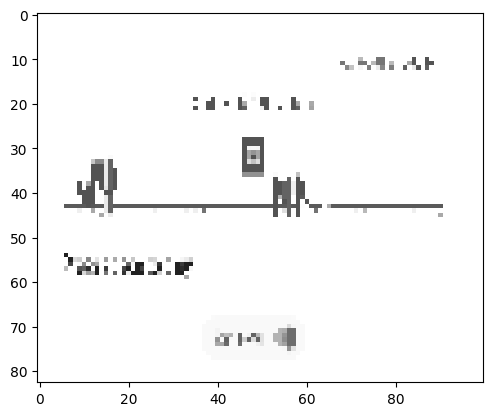

In [9]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [10]:
done, done_cap = env.get_done()

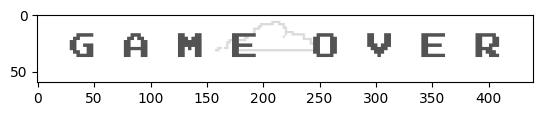

In [11]:
plt.imshow(done_cap)

In [ ]:
pytesseract.image_to_string(done_cap)[:4]

In [ ]:
for episode in range(2): 
    obs = env.reset()
    done = False  
    total_reward = 0
    while not done: 
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

 # 3. Train the Model

## 3.1 Create Callback

In [12]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [13]:
env_checker.check_env(env)

AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [16]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [17]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [18]:
env = WebGame()

In [19]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/larturi/anaconda3/envs/poc-dino-trex-ai/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/larturi/anaconda3/envs/poc-dino-trex-ai/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 1.51GB
  warnings.warn(


In [20]:
model.learn(total_timesteps=100, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.2     |
|    ep_rew_mean      | 15.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 25       |
|    total_timesteps  | 61       |
----------------------------------


In [21]:
 model.load('train_first/best_mode l_50000') 

FileNotFoundError: [Errno 2] No such file or directory: 'train_first/best_mode l_50000.zip'

# 4. Test out Model

In [54]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

KeyboardInterrupt: 